### Variable to calculate: Mean AMOC

## Notebook for calculating GCB 2023 evaluation metric: Mean AMOC, maximum at 26N


## Step 1, calculate AMOC using CDFtools

    ### process annotation

    `module add gcc/10.3.0`

    `module add netcdf/4.7.4/gcc`

    toolbox is here: `cd /gpfs/home/mep22dku/cdftools`

    need to symlink orca meshmask:

    do  `bash link_tommask.sh`

    bashscript for running the toolbox is in `overturning_TOM.sh` in the toolbox directory (change model name!)
    it puts results in `/gpfs/home/mep22dku/cdftools/MOCresults` with name of run in filename

#### AMOC references

https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019RG000644

https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2015RG000493

when a single-value AMOC number is required, the maximum at 26N is meant. 


### Step 2, open AMOC files as mfdataset, calculte max at 26 and save file. 


In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import numpy as np
from cmocean import cm
import matplotlib.pyplot as plt
import xarray as xr
import sys
import pandas as pd

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

In [3]:
ml = {
    'RW_ECO4' : {'desc' : 'RW_ECO4 (ERA5)',
                         'start': 1920,
                         'end' : 2022,
                       'color' : 'red',
                         'linestyle' : '-',
                      },
      'RW_GCBa' : {'desc' : 'RW_GCBa (ERA5)',
                         'start': 1948,
                         'end' : 1995,
                       'color' : 'navy',
                         'linestyle' : '-',
                      },
      'RW_CO2a' : {'desc' : 'RW_CO2a (ERA5)',
                         'start': 1920,
                         'end' : 2022,
                       'color' : 'gold',
                         'linestyle' : '-',
                      },
    'TJ_RVA0' : {'desc' : 'TJ_RVA0 \n (GCB23, ERA5)',
                     'start': 1945,
                     'end' : 2022,
                   'color' : 'grey',
                     'linestyle' : '-',
                  },
      
      'TJ_EA02' : {'desc' : 'TJ_EA02 \n (ECO, UKESM)',
                 'start': 1948,
                 'end' : 2099,
               'color' : 'red',
                 'linestyle' : ':',
              },
      
#         'TJ_GA01' : {'desc' : 'TJ_GA01 \n (GCB, UKESM)',
#              'start': 0,
#              'end' : 0,
#            'color' : 'navy',
#              'linestyle' : ':',
#           },
      
        'TJ_CA02' : {'desc' : 'TJ_CA02 \n (CO2, UKESM)',
             'start': 1948,
             'end' : 2099,
           'color' : 'gold',
             'linestyle' : ':',
          },    

          }


## step 2: concatenate and get maximum amoc

In [4]:


def make_yearlist(yrst, yrend, tr, baseDir = '/gpfs/home/mep22dku/cdftools/MOCresults/'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        tyr = yrs[i]
        ty = f'{baseDir}{tr}_1m_{tyr}0101*MOC.nc'
        t2 = glob.glob(ty)
        ylist.append(t2[0])
    return ylist

def get_max_amoc(moc_dataset):

    atl_at_26 = np.squeeze(moc_dataset.zomsfatl.sel(y=94).values)
    tshape = np.shape(atl_at_26)
    len_ts = tshape[0]

    max_atl = np.zeros(len_ts)

    for i in range(0,len(max_atl)):
        max_atl[i] = np.nanmax(atl_at_26[i,:])
        
    return max_atl

def make_amoc_nc(simulationID, yrFrom = 1959, yrTo = 2022):

    tmoc = xr.open_mfdataset(make_yearlist(yrFrom, yrTo, simulationID))
    tdat = get_max_amoc(tmoc)
    nicetime = tmoc.indexes['time_counter'].to_datetimeindex()

    resultsdir = '/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/'
    parm = 'AMOC'
    outputFile = f'{resultsdir}{parm}_{simulationID}_{yrFrom}-{yrTo}.nc'
    print(outputFile)
    
    data_vars = {'AMOC':(['TIME'], tdat,
    {'units': 'Sv',
    'long_name':'Atlantic Meridional Overturning Circulation, max of streamfunction at 26N'}),
    }
    # define coordinates
    coords = {'TIME': (['TIME'], nicetime)}
    # define global attributes
    attrs = {'made in':'AMOC-PLANKTOM/makeAMOC_modelts.ipynb',
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    ds.to_netcdf(outputFile)

In [5]:
extract = False
if extract:
    
    for m in ml:

        tnam = f'TOM12_{m}'
        tst = ml[m]['start']
        ten = ml[m]['end']
        print(f'{tnam} {tst} {ten}')
        make_amoc_nc(tnam, yrFrom = tst, yrTo = ten)


In [6]:
am = xr.open_dataset('./data/mocobs/moc_transports.nc')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


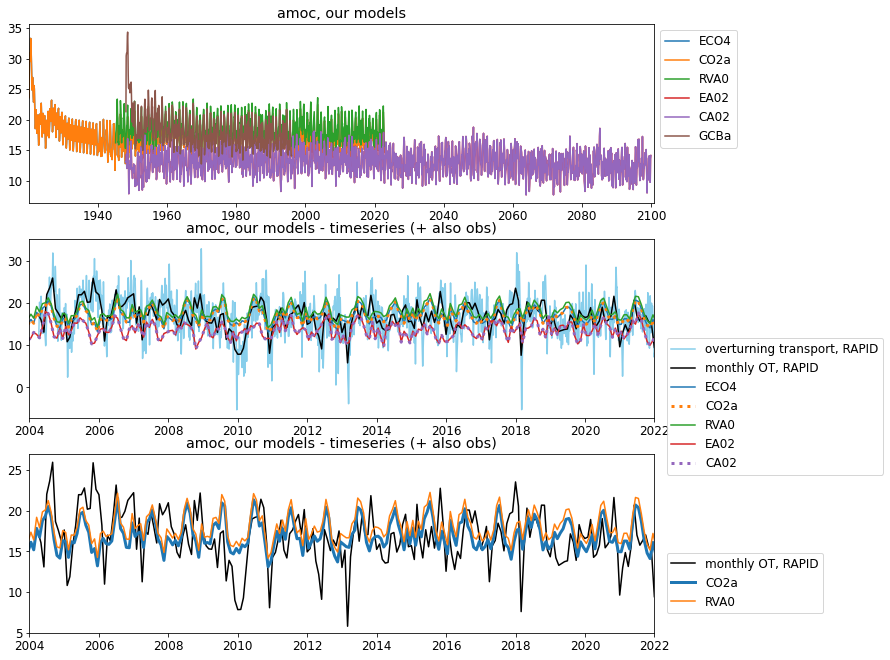

In [7]:

ECO4_amoc = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/AMOC_TOM12_RW_ECO4_1920-2022.nc')
GCBa_amoc = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/AMOC_TOM12_RW_GCBa_1948-1995.nc')
CO2a_amoc = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/AMOC_TOM12_RW_CO2a_1920-2022.nc')
RVA0_amoc = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/AMOC_TOM12_TJ_RVA0_1945-2022.nc')
EA02_amoc = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/AMOC_TOM12_TJ_EA02_1948-2099.nc')
CA02_amoc = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/AMOC_TOM12_TJ_CA02_1948-2099.nc')

fact = 0.7
fig, axs = plt.subplots(3,1, figsize=(16*fact, 16*fact), facecolor='w', edgecolor='k', sharey= False)
axs = axs.ravel()

axs[0].plot(ECO4_amoc.TIME, ECO4_amoc.AMOC, label = 'ECO4')
axs[0].plot(CO2a_amoc.TIME, CO2a_amoc.AMOC, label = 'CO2a')
axs[0].plot(RVA0_amoc.TIME, RVA0_amoc.AMOC, label = 'RVA0')
axs[0].plot(EA02_amoc.TIME, EA02_amoc.AMOC, label = 'EA02')
axs[0].plot(CA02_amoc.TIME, CA02_amoc.AMOC, label = 'CA02')
axs[0].plot(GCBa_amoc.TIME, GCBa_amoc.AMOC, label = 'GCBa')
axs[0].legend(bbox_to_anchor = [1,1])
axs[0].set_xlim(pd.Timestamp('1920-02-15'), pd.Timestamp('2101-01-01'))
axs[0].set_title('amoc, our models')

axs[1].plot(am.time,am.moc_mar_hc10, linestyle = '-', color = 'skyblue',  label = 'overturning transport, RAPID')
#monthly moc
monthly_moc = am['moc_mar_hc10'].resample(time='1MS').mean()
axs[1].plot(monthly_moc.time, monthly_moc, 'k-', label = 'monthly OT, RAPID')

axs[1].plot(ECO4_amoc.TIME, ECO4_amoc.AMOC, linestyle = '-', label = 'ECO4')
#axs[1].plot(GCBa_amoc.TIME, GCBa_amoc.AMOC, linestyle = ':', label = 'GCBa')
axs[1].plot(CO2a_amoc.TIME, CO2a_amoc.AMOC, linestyle = ':', linewidth = 3, label = 'CO2a')
axs[1].plot(RVA0_amoc.TIME, RVA0_amoc.AMOC, linestyle = '-', label = 'RVA0')
axs[1].plot(EA02_amoc.TIME, EA02_amoc.AMOC, label = 'EA02')
axs[1].plot(CA02_amoc.TIME, CA02_amoc.AMOC, linestyle = ':', linewidth = 3, label = 'CA02')



axs[1].set_xlim(pd.Timestamp('2004-01-01'), pd.Timestamp('2022-01-01'))
axs[1].set_title('amoc, our models - timeseries (+ also obs)')
axs[1].legend(bbox_to_anchor = [1.01,0.48])


axs[2].plot(monthly_moc.time, monthly_moc, 'k-', label = 'monthly OT, RAPID')
axs[2].plot(CO2a_amoc.TIME, CO2a_amoc.AMOC, linestyle = '-', linewidth = 3, label = 'CO2a')
axs[2].plot(RVA0_amoc.TIME, RVA0_amoc.AMOC, linestyle = '-', label = 'RVA0')
axs[2].set_xlim(pd.Timestamp('2004-01-01'), pd.Timestamp('2022-01-01'))
axs[2].set_ylim([5,27])
axs[2].set_title('amoc, our models - timeseries (+ also obs)')
axs[2].legend(bbox_to_anchor = [1.01,0.48])

timeseries

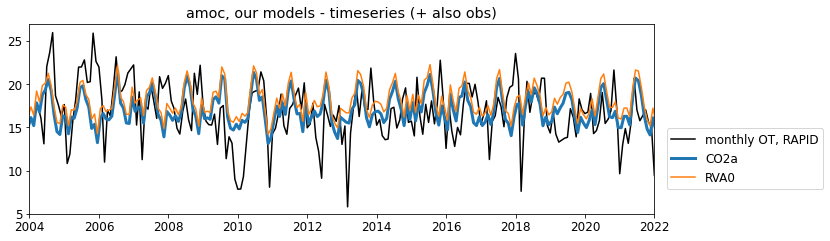

In [8]:

ECO4_amoc = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/AMOC_TOM12_RW_ECO4_1920-2022.nc')
GCBa_amoc = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/AMOC_TOM12_RW_GCBa_1948-1995.nc')
CO2a_amoc = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/AMOC_TOM12_RW_CO2a_1920-2022.nc')
RVA0_amoc = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/AMOC_TOM12_TJ_RVA0_1945-2022.nc')
EA02_amoc = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/AMOC_TOM12_TJ_EA02_1948-2099.nc')
CA02_amoc = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/AMOC_TOM12_TJ_CA02_1948-2099.nc')

fact = 0.7
fig, axs = plt.subplots(1,1, figsize=(16*fact, 5*fact), facecolor='w', edgecolor='k', sharey= False)
# axs = axs.ravel()


axs.plot(monthly_moc.time, monthly_moc, 'k-', label = 'monthly OT, RAPID')
axs.plot(CO2a_amoc.TIME, CO2a_amoc.AMOC, linestyle = '-', linewidth = 3, label = 'CO2a')
axs.plot(RVA0_amoc.TIME, RVA0_amoc.AMOC, linestyle = '-', label = 'RVA0')
axs.set_xlim(pd.Timestamp('2004-01-01'), pd.Timestamp('2022-01-01'))
axs.set_ylim([5,27])
axs.set_title('amoc, our models - timeseries (+ also obs)')
axs.legend(bbox_to_anchor = [1.01,0.48])

R^2 CO2a: 0.0659898134196357
R^2 RVA0: 0.06634059384840331
obs amoc trend/yr -0.11680135896238279
CO2a amoc trend/yr -0.004668544473967138
RVA0 amoc trend/yr 0.010279449044737777


Text(0.5, 1.0, 'obs amoc trend/yr -0.11680135896238279 \n CO2a amoc trend/yr -0.004668544473967138 RVA0 amoc trend/yr 0.010279449044737777')

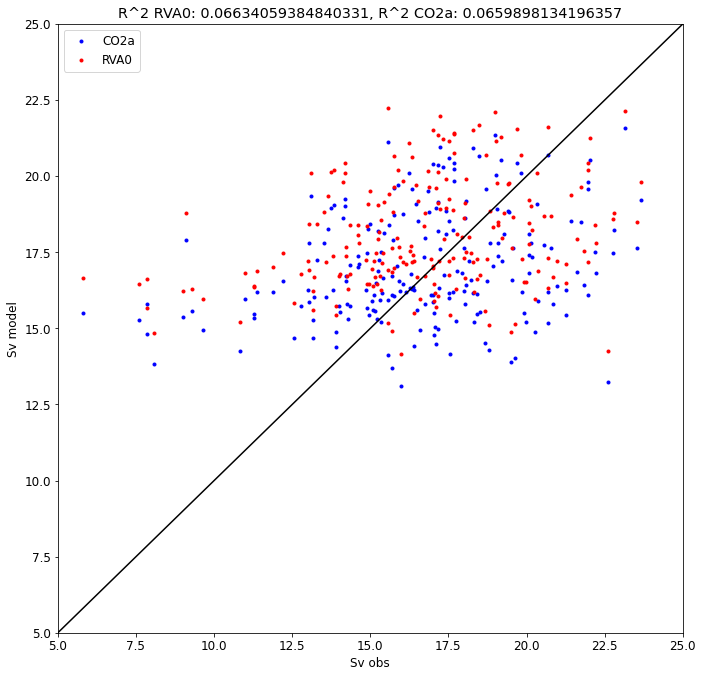

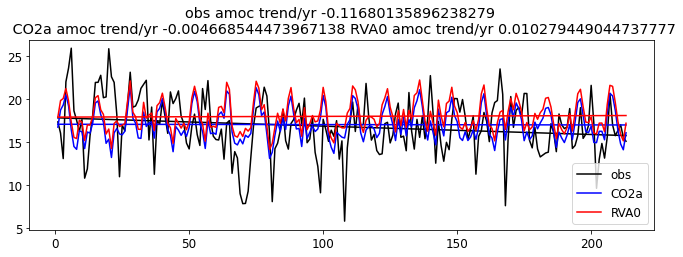

In [9]:
from scipy import stats

obs_vyrez = monthly_moc.sel(time=slice(f'2004-04-01', f'2021-12-31')).values
CO2a_vyrez = CO2a_amoc.AMOC.sel(TIME=slice(f'2004-04-01', f'2021-12-31')).values
RVA0_vyrez = RVA0_amoc.AMOC.sel(TIME=slice(f'2004-04-01', f'2021-12-31')).values


fact = 0.7
fig, axs = plt.subplots(1,1, figsize=(16*fact, 16*fact), facecolor='w', edgecolor='k', sharey= False)
# axs = axs.ravel()

axs.plot(obs_vyrez,CO2a_vyrez, 'b.', label = 'CO2a')
axs.plot(obs_vyrez,RVA0_vyrez, 'r.', label = 'RVA0')
axs.set_xlabel('Sv obs'); axs.set_ylabel('Sv model')
slope, intercept, r_value, p_value, std_err = stats.linregress(obs_vyrez, CO2a_vyrez)
# R^2 calculation
r_squared1 = r_value**2
print("R^2 CO2a:", r_squared1)

slope, intercept, r_value, p_value, std_err = stats.linregress(obs_vyrez, RVA0_vyrez)
# R^2 calculation
r_squared2 = r_value**2
print("R^2 RVA0:", r_squared2)
axs.set_title(f'R^2 RVA0: {r_squared2}, R^2 CO2a: {r_squared1}')

axs.set_xlim([5,25])
axs.set_ylim([5,25])
axs.plot([5,25],[5,25],'k-')
axs.legend(loc = 'best')

fig, axs = plt.subplots(1,1, figsize=(16*fact, 5*fact), facecolor='w', edgecolor='k', sharey= False)
ts = np.arange(1,214,1)

axs.plot(ts,obs_vyrez, color = 'k', label = 'obs')
slope1, intercept, r_value, p_value, std_err = stats.linregress(ts, obs_vyrez)
print(f'obs amoc trend/yr {slope1*12}')
axs.plot(ts, ts*slope1+intercept, color = 'k')

axs.plot(ts,CO2a_vyrez, color = 'b', label = 'CO2a')
slope2, intercept, r_value, p_value, std_err = stats.linregress(ts, CO2a_vyrez)
print(f'CO2a amoc trend/yr {slope2*12}')
axs.plot(ts, ts*slope2+intercept, color = 'b')

axs.plot(ts,RVA0_vyrez, color = 'r', label = 'RVA0')
slope3, intercept, r_value, p_value, std_err = stats.linregress(ts, RVA0_vyrez)
print(f'RVA0 amoc trend/yr {slope3*12}')
axs.plot(ts, ts*slope3+intercept, color = 'r')
axs.legend(loc = 'best')
axs.set_title(f'obs amoc trend/yr {slope1*12} \n CO2a amoc trend/yr {slope2*12} RVA0 amoc trend/yr {slope3*12}')